In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
import pandas as pd
from glob import glob
from fastcore.xtras import load_pickle, save_pickle
from pathlib import Path

from sklearn.model_selection import train_test_split
from pycm import ConfusionMatrix
import optuna

import numpy as np
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
import time
import os
import shap

from plotutils.plotutils import *

plt.style.use("plotutils/kevin.mplstyle")


import matplotlib.pyplot as plt

from pymatgen.io.ase import AseAtomsAdaptor

from pymatgen.core import Structure

from visualization import create_atoms_with_color_arrays, show_atoms

In [4]:
# Classifier that performs optuna hyperopt in the fit call
class XGBoostOptunaClassifier(xgb.XGBClassifier):
    def __init__(self, n_trials=100, **kwargs):
        super().__init__(**kwargs)
        self.n_trials = n_trials

    def fit(self, X, y, seed, *args, **kwargs):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        def objective(trial):
            params = {
                "learning_rate": trial.suggest_float(
                    "learning_rate", 1e-2, 0.25, log=True
                ),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),
                "subsample": trial.suggest_float("subsample", 0.1, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
                "max_depth": trial.suggest_int("max_depth", 1, 9),
                "n_estimators": trial.suggest_categorical(
                    "n_estimators", [7000, 15000, 20000]
                ),
            }

            model = xgb.XGBClassifier(**params)
            model.fit(
                X_train,
                y_train,
                early_stopping_rounds=10,
                eval_set=[(X_val, y_val)],
                verbose=False,
            )

            y_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            return 1.0 - accuracy

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=self.n_trials)

        self.best_params_ = study.best_params
        super().set_params(**self.best_params_)

        return super().fit(X, y, *args, **kwargs)

In [5]:
all_data = pd.read_pickle("../data/all_data.pkl")
feature_names = load_pickle("../data/feature_names.pkl")
subset = all_data[all_data["below_benchmark"]]
feature_names = [f for f in all_data.columns if "phimage" in f]

In [33]:
train, test = train_test_split(
    subset, train_size=0.8, stratify=subset["below_water_benchmark"]
)

In [34]:
model = XGBoostOptunaClassifier(n_trials=100)
model.fit(
    train[feature_names].values, train["below_water_benchmark"].astype(int), seed=42
)

[I 2023-06-13 16:40:21,732] A new study created in memory with name: no-name-4d7d5059-a860-484c-a7cf-7d802699fe46
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2023-06-13 16:40:25,349] Trial 0 finished with value: 0.11290322580645162 and parameters: {'learning_rate': 0.01082533944565664, 'reg_lambda': 3.7704431717161325e-05, 'reg_alpha': 8.749309764976163e-07, 'subsample': 0.8508254097754012, 'colsample_bytree': 0.43994044238647945, 'max_depth': 6, 'n_estimators': 20000}. Best is trial 0 with value: 0.11290322580645162.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2023-06-13 16:40:26,281] Trial 1 finished with value: 0.17741935483870963 and parameters: {'learning_rate': 0.036359641911852106, 'reg_lambda': 0.21941066617057786, 'reg_alpha': 2.2312

[16:43:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_trials" } are not used.



XGBoostOptunaClassifier(base_score=None, booster=None, callbacks=None,
                        colsample_bylevel=None, colsample_bynode=None,
                        colsample_bytree=0.5725162155329254,
                        early_stopping_rounds=None, enable_categorical=False,
                        eval_metric=None, feature_types=None, gamma=None,
                        gpu_id=None, grow_policy=None, importance_type=None,
                        interaction_constraints=None,
                        learning_rate=0.021859808016869705, max_bin=None,
                        max_cat_threshold=None, max_cat_to_onehot=None,
                        max_delta_step=None, max_depth=3, max_leaves=None,
                        min_child_weight=None, missing=nan,
                        monotone_constraints=None, n_estimators=20000,
                        n_jobs=None, num_parallel_tree=None,
                        objective='binary:logistic', predictor=None, ...)

In [35]:
predictions = model.predict(test[feature_names])

In [36]:
cm = ConfusionMatrix(test["below_water_benchmark"].values.astype(int), predictions)

In [37]:
print(cm)

Predict  0        1        
Actual
0        7        6        

1        2        62       





Overall Statistics : 

95% CI                                                            (0.82795,0.96426)
ACC Macro                                                         0.8961
ARI                                                               0.49633
AUNP                                                              0.75361
AUNU                                                              0.75361
Bangdiwala B                                                      0.87111
Bennett S                                                         0.79221
CBA                                                               0.72511
CSI                                                               0.59838
Chi-Squared                                                       26.93028
Chi-Squared DF                                                    1
Conditional Entropy                                           

In [38]:
model = xgb.XGBClassifier(**model.best_params_)
model.fit(subset[feature_names].values, subset["below_water_benchmark"].astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5725162155329254, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.021859808016869705,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [30]:
save_pickle("../models/20230613-model-water-cement_all.pkl", model)

## Now, get the SHAP feature importance


In [7]:
explainer = shap.TreeExplainer(model)

In [8]:
shap_values = explainer.shap_values(
    subset[subset["below_water_benchmark"]].sort_values(
        by="water_resistance", ascending=True
    )[feature_names]
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


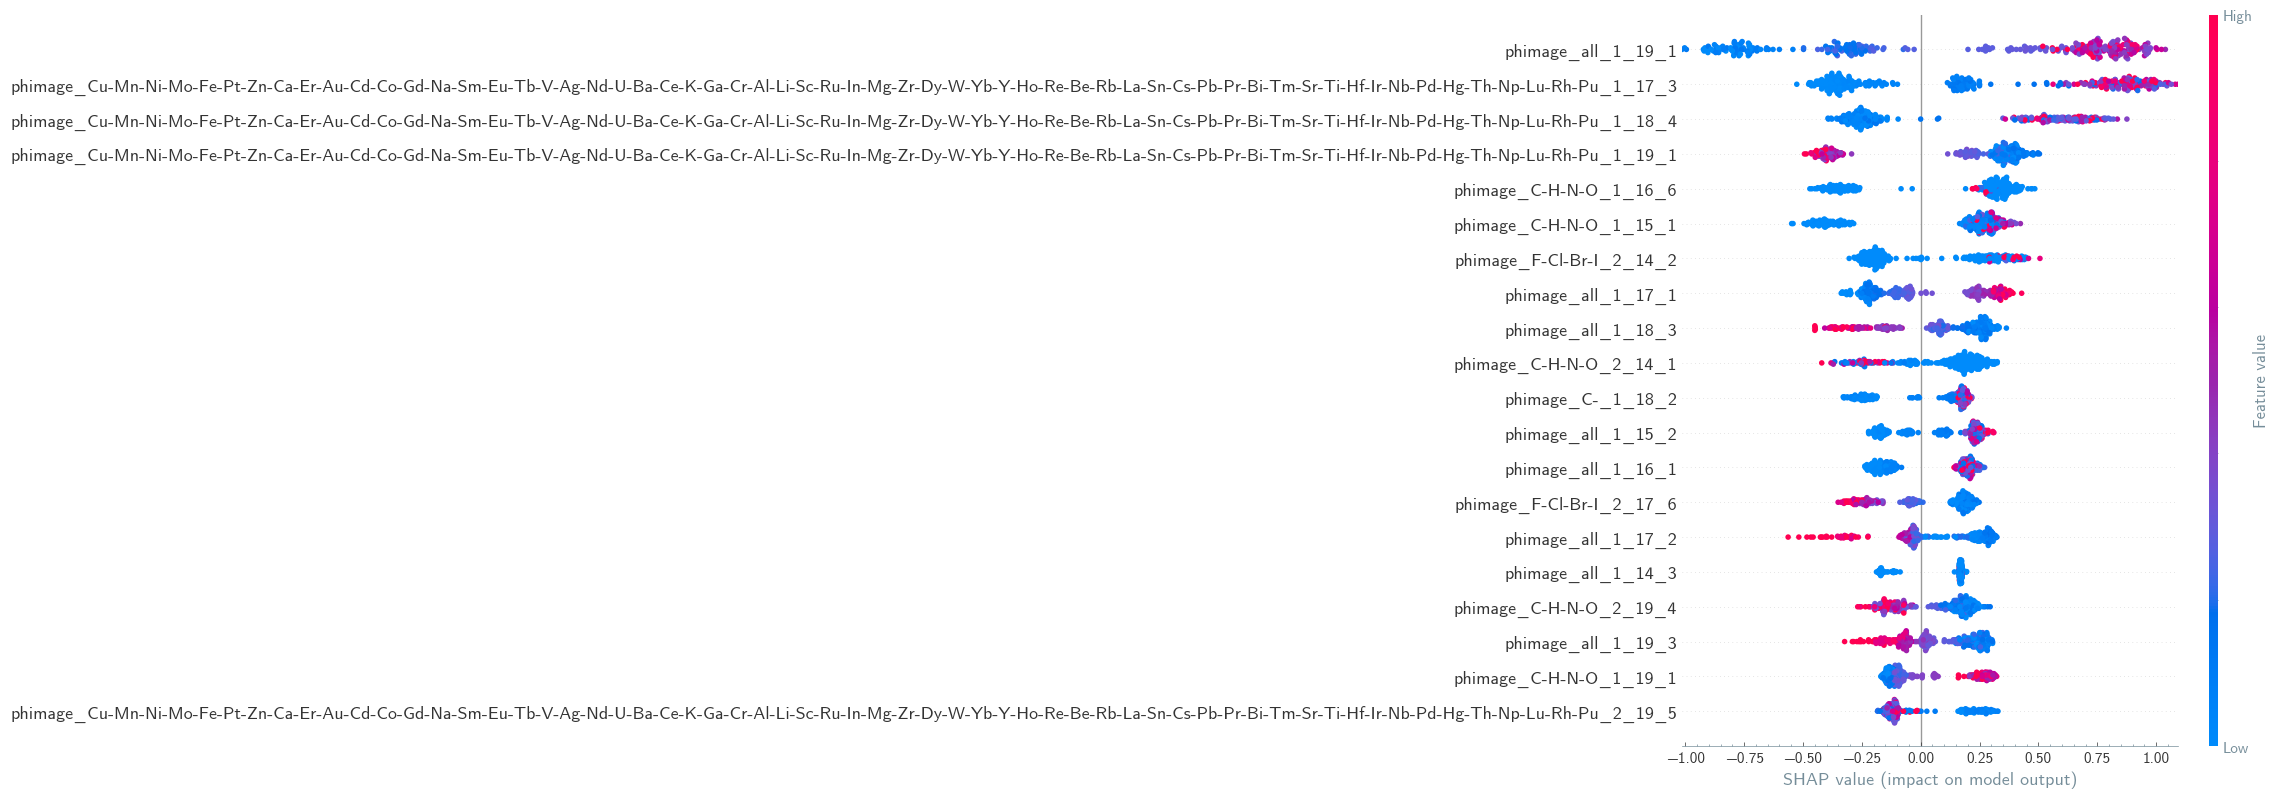

In [9]:
shap.summary_plot(
    shap_values,
    features=subset[subset["below_water_benchmark"]].sort_values(
        by="water_resistance", ascending=True
    )[feature_names],
    feature_names=feature_names,
)

In [10]:
dim_0_indices = []
dim_1_indices = []
dim_2_indices = []

c_indices = []
halogen_indices = []
metal_indices = []
all_indices = []
chno_indices = []

for i, name in enumerate(feature_names):
    dim = int(name.split("_")[-3])
    if dim == 0:
        dim_0_indices.append(i)
    elif dim == 1:
        dim_1_indices.append(i)
    elif dim == 2:
        dim_2_indices.append(i)

    elem = name.split("_")[1]

    if elem == "C-":
        c_indices.append(i)
    elif "Cu" in elem:
        metal_indices.append(i)
    elif "F" in elem:
        halogen_indices.append(i)
    elif "all" in elem:
        all_indices.append(i)
    else:
        chno_indices.append(i)

In [11]:
dim_0_importance = model.feature_importances_[np.array(dim_0_indices)].sum()
dim_1_importance = model.feature_importances_[np.array(dim_1_indices)].sum()
dim_2_importance = model.feature_importances_[np.array(dim_2_indices)].sum()

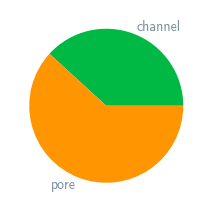

In [12]:
plt.pie(
    [dim_0_importance, dim_1_importance, dim_2_importance],
    labels=["", "channel", "pore"],
)
plt.savefig("../visuals/ph_dim_importance_water.pdf", bbox_inches="tight")
# plt.savefig('../visuals/ph_dim_importance_nCAC.png', dpi=400, bbox_inches='tight')

In [13]:
c_importance = model.feature_importances_[np.array(c_indices)].sum()
halogen_importance = model.feature_importances_[np.array(halogen_indices)].sum()
metal_importance = model.feature_importances_[np.array(metal_indices)].sum()
all_importance = model.feature_importances_[np.array(all_indices)].sum()
chno_importance = model.feature_importances_[np.array(chno_indices)].sum()

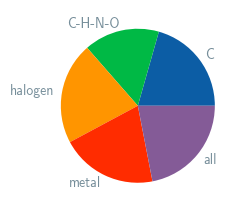

In [14]:
plt.pie(
    [
        c_importance,
        chno_importance,
        halogen_importance,
        metal_importance,
        all_importance,
    ],
    labels=["C", "C-H-N-O", "halogen", "metal", "all"],
)
# plt.savefig('ph_chem_importance.pdf', bbox_inches='tight')
plt.savefig("../visuals/ph_chem_importance_water.pdf", bbox_inches="tight")

### Now, let's look on a case-by-case basis what the most important features are


In [15]:
from mofdscribe.featurizers.topology.ph_image import PHImage
from ase.io import read, write

In [16]:
featurizer = PHImage(
    atom_types=(
        "C-H-N-O",
        "C-",
        "F-Cl-Br-I",
        "Cu-Mn-Ni-Mo-Fe-Pt-Zn-Ca-Er-Au-Cd-Co-Gd-Na-Sm-Eu-Tb-V"
        "-Ag-Nd-U-Ba-Ce-K-Ga-Cr-Al-Li-Sc-Ru-In-Mg-Zr-Dy-W-Yb-Y-"
        "Ho-Re-Be-Rb-La-Sn-Cs-Pb-Pr-Bi-Tm-Sr-Ti-Hf-Ir-Nb-Pd-Hg-"
        "Th-Np-Lu-Rh-Pu",
    ),
    spread=0.15,
    min_size=100,
    max_fit_tolerance=0.2,
)

featurizer.max_b = [0.0, 11.85585823059082, 11.856735992431641, 0.0]
featurizer.max_p = [8.401015663146973, 8.07491397857666, 4.6178689956665036, 0.0]

In [19]:
names = subset[subset['below_water_benchmark']].sort_values(by='water_resistance', ascending=False).iloc[:10]['MOF_x'].values

In [20]:
names

array(['RSM0281', 'str_m2_o5_o29_pcu_sym.50', 'RSM2729', 'RSM0226',
       'RSM2771', 'RSM3065', 'str_m5_o11_o16_sra_sym.189', 'RSM0794',
       'RSM1112', 'RSM0158'], dtype=object)

In [57]:
for name in names:
    write(f'../visuals/top_water_structures_ml/{name}.png', read(f'../data/CIF-Files/{name}.cif'))

In [ ]:
def create_subset_structure(s, indices):
    return Structure.from_sites([s for i, s in enumerate(s) if i in indices])

In [72]:
def show_atoms_new(atoms, filename, zoom=1.0, repeat_uc=(2, 2, 2), show_cell=True, lighten_by_depth=True, show_bonds=False, bond_radii_scale=1):
    from ase_notebook import concatenate_svgs
    from ase_notebook.backend.svg import svg_to_pdf
    from ase_notebook import AseView, ViewConfig, get_example_atoms
    from IPython.display import SVG
    config = ViewConfig()
    ase_view = AseView(config)
    ase_view.config.canvas_background_opacity = 0.0
    ase_view.config.atom_colormap = 'vesta'

    ase_view.config.atom_color_by = 'color_array'
    ase_view.config.atom_color_array = 'color_array'
    ase_view.config.atom_opacity_by = 'opacity_array'
    ase_view.config.atom_show_label = False #True

    ase_view.config.show_bonds = show_bonds
    ase_view.config.bond_radii_scale =bond_radii_scale
    if lighten_by_depth:
        ase_view.config.atom_lighten_by_depth = 0.3
    ase_view.config.zoom = zoom
    ase_view.config.show_unit_cell = show_cell

    ase_view.config.atom_stroke_width = 0.001
    ase_view.config.atom_stroke_opacity = 0.1

    print('HELLOO')
    svgs = []
    for rot in ["45x,45y,45z", "90z", "90x", "90y"]:
        ase_view.config.rotations = rot
        svgs.append(
            ase_view.make_svg(atoms, center_in_uc=True, repeat_uc=repeat_uc)
        )
    svg = concatenate_svgs(
        svgs, max_columns=2, scale=0.5, label=True
    )

    svg_f = SVG(svg.tostr().decode('utf-8'))
    if filename is not None:
        svg_to_pdf(svg_f.data, filename)
    return svg

In [1]:
for i in range(10):
    for j in range(8):
        name = names[i]
        try:
            feature_index = j
            sorted_index_array = np.argsort(shap_values[i,:])[::-1]
            sorted_feature_names = np.array(feature_names)[sorted_index_array]
            sorted_feature_names[feature_index]
            s = Structure.from_file(f'../data/CIF-Files//{name}.cif')
            mol= featurizer.find_relevant_substructure(s, sorted_feature_names[feature_index])
            show_atoms_new(create_atoms_with_color_arrays(s, mol.original_structure_indices), f'../visuals/top_water_fragments/{name}_{feature_index}_{sorted_feature_names[feature_index]}.pdf',)
            subset_structure = create_subset_structure(s, mol.original_structure_indices)
            subset_structure.to(f'../visuals/top_water_fragments/{name}_{feature_index}_{sorted_feature_names[feature_index]}.cif')
        except Exception as e:
            print(name, feature_index,  sorted_feature_names[feature_index], e)

NameError: name 'names' is not defined